## Imports

In [1]:
# For OS interaction and system-specific parameters
import os
import sys

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torch.optim.lr_scheduler import StepLR

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets


# Albumentations for Data Augmentation
import albumentations as A

# PIL for image operations
from PIL import Image
from PIL import ImageOps

# Matplotlib for plotting and visualizations
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# TensorBoardX - TensorBoard for PyTorch
from tensorboardX import SummaryWriter

# CodeCarbon for tracking our carbon emissions
from codecarbon import EmissionsTracker

# tqdm for showing progress bars
from tqdm.notebook import tqdm

# Add scripts to directory
sys.path.append('C:\\Users\\jacob\\OneDrive\\Desktop\\SyntheticEye\\Development\\scripts')

# Import custom helper functions from the scripts directory
import helper_functions

# For implementing different learning rates for different layers in the optimizer
from itertools import chain

## Visualize Dimensions of Images in Classes
This helps us with:
- Understanding our data
- Choosing a fixed image size

In [2]:
# Import plot_image_dimensions function from helper_functions.py
from helper_functions import plot_image_dimensions

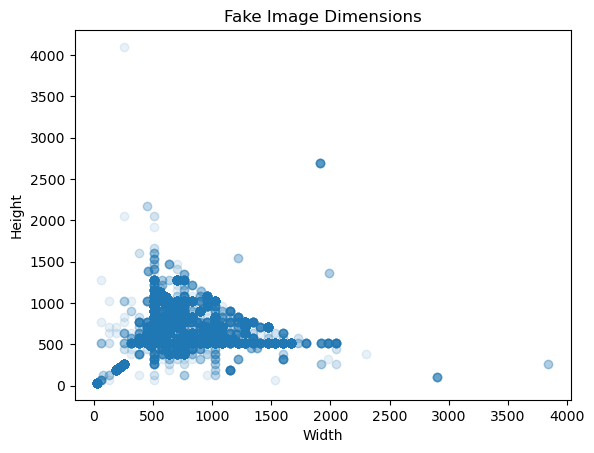

In [3]:
# Plot dimensions of ai-generated images
img_dir = "/Users/jacob/OneDrive/Desktop/image-dataset/dataset_1/Fake"
plot_image_dimensions(img_dir, heading='Fake Image Dimensions')

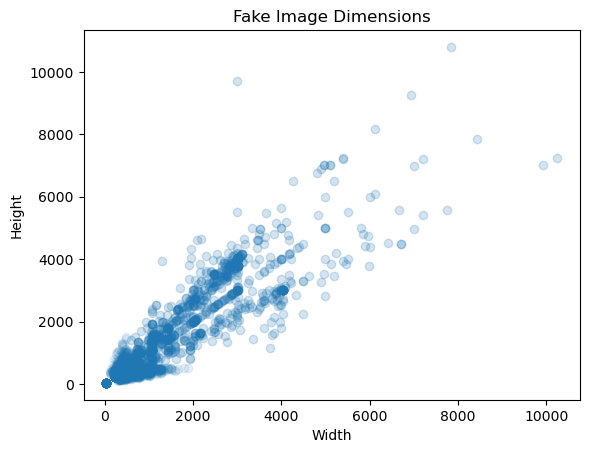

In [4]:
# Plot dimensions of real images
img_dir = "/Users/jacob/OneDrive/Desktop/image-dataset/dataset_1/Real"
plot_image_dimensions(img_dir, heading='Fake Image Dimensions')

## Create Neural Network Architecture
We will reuse the architecture from our face detection model. This architecture includes convolutional layers with residual blocks, followed by fully connected layers for classification.
Using the same architecture allows us to utilize transfer learning.

In [ ]:
class ResBlock(nn.Module):
    """
    A residual block that consists of a convolutional block and a skip connection.
    """
    def __init__(self, in_channels, out_channels, dropout_prob=0.2):
        super(ResBlock, self).__init__()
        
        # Define main convolutional block
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob)
        )
        
        # Define skip connection and adapt channels
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    
    # Pass input through main block and add skip connection
    def forward(self, x):
        out = self.block(x)
        res = self.residual(x)
        return out + res

class AdjustedResCNN(nn.Module):
    """
    This is the architecture of our currently deployed face detection model (Aletheia). 
    We reuse this architceture for this general image detection model (Argus). 
    """
    def __init__(self, dropout_prob=0.3):
        super(AdjustedResCNN, self).__init__()

        # Convolutional layers with residual blocks and max-pooling. The dropout probability is reduced for the convolutional layers
        self.conv_layers = nn.Sequential(
            ResBlock(3, 24, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(24, 48, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(48, 96, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(96, 192, dropout_prob * 0.2),
            nn.MaxPool2d(2)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_size(), 448),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(448, 224),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(224, 112),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(112, 1) # Final layer with one output for our binary classification problem
        )

    def feature_size(self):
        """
        Compute size of flattend features after passing through the convolutional layers.
        This is useful for determining the input size for the fully connected layers
        """
        return self.conv_layers(torch.zeros(1, 3, 224, 224)).view(1, -1).size(1)

    def forward(self, x):
        # Pass input through convolutional layers
        x = self.conv_layers(x)
        # Flatten tensor
        x = x.view(x.size(0), -1) 
        # Pass flattened tensor through fully connected layers
        x = self.fc_layers(x)
        return x

## Set Up Device Agnostic Code

In [ ]:
# Set the device to GPU if available, else use the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

## Hyperparameters

In [ ]:
# Define Hyperparameters
num_classes = 2
batch_size = 32
num_epochs = 16

## Data
- Load datasets 
- Split data
- Apply transformations to images and utilize data augmentation

In [ ]:
class CustomDataset(Dataset):
    """
    Custom Dataset for loading images with albumentations transforms
    """
    def __init__(self, img_paths, label_list, transform=None):
        self.img_paths = img_paths
        self.label_list = label_list
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        
        # Ensure the image is RGB
        if img.mode != 'RGB':
            img = img.convert('RGB') 
        
        img = np.array(img)
        
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']

        label = self.label_list[index]
        return img, label

### Define Mean and Standard Deviation of Images
Since transfer learning from Aletheia is used, we have to use the normalization values of the Aletheia dataset

In [ ]:
# Mean and standard deviation from Aletheia dataset, since transfer learning is used 
mean = [0.499, 0.415, 0.372]
std = [0.245, 0.223, 0.220]

### Define Image Transformations
Utilize data augmentation

In [ ]:
class AlbumentationsTransform:
    """
    Class to transform images using the Albumentations library
    """
    def __init__(self, transform=None):
        self.transform = transform

    # Apply Albumentations transform to the input image and convert the result to a tensor.
    def __call__(self, img):
        # Convert image to numpy array
        if isinstance(img, Image.Image):
            img = np.array(img)
        
        # Convert augmented image to a tensor and normalize pixel values
        augmented = self.transform(image=img)
        img_tensor = torch.from_numpy(augmented['image'].transpose(2, 0, 1)).float()  / 255.0
        return img_tensor

In [ ]:
class TorchvisionBridge:
    """
    Bridge to convert Torchvision transforms into a format that can be used with the Albumentations library.
    """
    def __init__(self, transform):
        self.transform = transform

    # Apply torchvision transformations and convert the results to a numpy array
    def __call__(self, img):
        img = self.transform(img)
        return np.array(img)

In [ ]:
# Train Transformations

# Albumentations transformations
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.Rotate(limit=15, p=0.5),
    A.PixelDropout(dropout_prob=0.015, p=0.3),
    A.Normalize(mean=mean, std=std), 
])
# Torchvision transformations
train_torchvision_transform = transforms.Compose([
    transforms.RandomAffine(degrees=8, translate=(0.08, 0.08)),
    transforms.Resize((224, 224)) 
])

# Test Transformations

# Albumentations transformations
test_transform = A.Compose([
    A.Normalize(mean=mean, std=std), 
])

# Torchvision transformations
test_torchvision_transform = transforms.Compose([
    transforms.Resize((224, 224))
])

# This is used when testing the model on a specific source
test_augmentation = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=mean, std=std)
])

In [ ]:
class CustomDataset(Dataset):
    """
    This Custom Dataset class is used to incorporate Torchvision and Albumentation transformations.
    """

    # Initialize CustomDataset Object
    def __init__(self, dataset, torchvision_transforms=None, albumentations_transform=None):
        self.dataset = dataset
        self.torchvision_transforms = torchvision_transforms
        self.albumentations_transform = AlbumentationsTransform(albumentations_transform)

    # Return number of samples in the dataset
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        # Check if dataset is a subset and get the path and target accordingly
        if isinstance(self.dataset, torch.utils.data.Subset):
            path, target = self.dataset.dataset.samples[self.dataset.indices[index]]
        else:
            path, target = self.dataset.samples[index]
        
        img = Image.open(path).convert("RGB")

        # Apply torchvision transforms
        if self.torchvision_transforms:
            img = self.torchvision_transforms(img)
        
        # Apply albumentations transforms
        if self.albumentations_transform:
            img = self.albumentations_transform(img)
        
        return img, target

In [ ]:
root_directory = '/Users/jacob/OneDrive/Desktop/image-dataset/dataset_1/'

# Load dataset without transformations
full_dataset = datasets.ImageFolder(root=root_directory)

# Set random seed for reproducibility
torch.manual_seed(3)

# Split dataset into train, validation, and test sets
train_size = int(0.85 * len(full_dataset))  # 85%
validation_size = int(0.05 * len(full_dataset))  # 5%
test_size = len(full_dataset) - train_size - validation_size  # 10%

train_subset, validation_subset, test_subset = random_split(full_dataset, [train_size, validation_size, test_size])

# Apply transformations using the CustomDataset class
train_dataset = CustomDataset(
    train_subset, 
    torchvision_transforms=train_torchvision_transform, 
    albumentations_transform=train_transform
)

# Apply transformations to validation dataset
val_dataset = CustomDataset(
    validation_subset, 
    torchvision_transforms=test_torchvision_transform, 
    albumentations_transform=test_transform
)

# Apply transformations to test dataset
test_dataset = CustomDataset(
    test_subset, 
    torchvision_transforms=test_torchvision_transform, 
    albumentations_transform=test_transform
)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Training

### Prepare Training

In [ ]:
from helper_functions import check_accuracy

In [ ]:
# Set a random seed for reproducibility
torch.manual_seed(3)

# Initialize model and transfer it to the GPU if available
model = AdjustedResCNN().to(device)
# Load trained model for transfer learning (from Alteheia 2.5)
model.load_state_dict(torch.load("/Users/jacob/OneDrive/Desktop/SyntheticEyeLocal/StateDicts/Aletheia/2_5/al2_5_epoch_16_correct235028.pth"))
model.to(device)

In [ ]:
# Use BCEWithLogitsLoss for our binary classification problem
loss_function = nn.BCEWithLogitsLoss()

In [ ]:
# Initialize TensorBoard summary writer
writer = SummaryWriter(f'runs/Argus2_5')
step = 0

### Train Model

Using transfer learning and training different layers with different learning rates

In [ ]:
#  Group Layers
early_conv_layers = list(model.conv_layers.children())[:3]  
middle_conv_layers = list(model.conv_layers.children())[3:6]  
fc_layers = list(model.fc_layers.children())

# Create Parameter Groups for different learning rates
param_groups = [
    {'params': chain(*[layer.parameters() for layer in early_conv_layers]), 'lr': 0.000001},
    {'params': chain(*[layer.parameters() for layer in middle_conv_layers]), 'lr': 0.00001},
    {'params': chain(*[layer.parameters() for layer in fc_layers]), 'lr': 0.0001},
]

# Initialize Optimizer with Parameter Groups
optimizer = torch.optim.NAdam(param_groups)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
    
# Initialize EmissionsTracker to monitor carbon emissions using CodeCarbon
carbon_tracker = EmissionsTracker(project_name="Argus2_5_Emissions", log_level="critical")
carbon_tracker.start()

# Initialize tracking of correct predictions and total predictions
correct = 0
samples = 0

torch.manual_seed(3)

model = model.to(device)

# Set up log interval for recording metrics
metrics_interval = 200

# Initialize variables for accuracy and loss values
training_loss = 0.0
training_accuracy = 0.0



for epoch in range(num_epochs):
    # Reset accuracy counters at beginning of each epoch
    correct = 0
    samples = 0

    # Switch model to training mode
    model.train()

    # Train model on each batch of train_loader
    for batch_index, (data, targets) in tqdm(enumerate(train_loader), total=len(train_loader), desc="Progress in epoch"):
        # Move data and targets to the device
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = model(data)
        scores = scores.squeeze(1)
        loss = loss_function(scores.view(-1), targets.float())  # Compute loss based on model's predictions

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Convert to binary decisions
        preds = (torch.sigmoid(scores) > 0.5).float()

        # Update accuracy counters
        correct += (preds == targets).sum().item()
        samples += preds.size(0)
        # Calculate accuracy as a percentage
        accuracy = 100 * correct / samples

        if batch_index % metrics_interval == 0:
            # Log metrics to TensorBoard
            writer.add_scalar('Training Loss', loss, epoch * len(train_loader) + batch_index)
            writer.add_scalar('Training Accuracy', accuracy, epoch * len(train_loader) + batch_index)
            # Print metrics
            print("Epoch: ", epoch)
            print(f'Got {correct} / {samples} correct with an accuracy {accuracy:.2f}% on training data.')

    # Update learning rate
    scheduler.step()

    # Print accumulated accuracy for epoch
    print("Epoch: ", epoch)
    print(f'Got {correct} / {samples} correct with accuracy of {accuracy:.2f}% on training data.')

    # Evaluate model on validation set after epoch
    model.eval()
    correct_test, samples_test = check_accuracy(val_loader, model, device)
    test_accuracy = 100 * float(correct_test) / float(samples_test)
    
    # Log test accuracy to TensorBoard
    writer.add_scalar('Test Accuracy', test_accuracy, epoch)
    
    # Save state of model after epoch
    torch.save(model.state_dict(), f'/Users/jacob/OneDrive/Desktop/SyntheticEyeLocal/StateDicts/Argus/Argus2Beta/ar2_5_epoch_{epoch}_correct{correct}.pth')

# Stop EmissionsTracker
emissions = carbon_tracker.stop()

# Display total carbon emissions
print(f"Emissions: {emissions:.6f} kgCO2eq")

# Close TensorBoard writer
writer.close()

## Test Model

In [ ]:
model = AdjustedResCNN().to(device)

# Create a dummy input and perform a forward pass to create the fc1 layer
sample_input = torch.randn(1, 3, 224, 224).to(device)
model(sample_input)

# Specify path to the trained model weights
model_path = "C:\\Users\\jacob\\OneDrive\\Desktop\\SyntheticEyeLocal\\StateDicts\\Argus\\Argus2Beta\\ar2_5_epoch_3_correct229925.pth"

# Load trained weights into the model
model.load_state_dict(torch.load(model_path))

model = model.to(device)

In [ ]:
check_accuracy(test_loader, model, device)

In [ ]:
from helper_functions import predict_single_image

In [ ]:
img_path = "/Users/jacob/OneDrive/Desktop/ai.jpg"
predicted_label = predict_single_image(
    img_path, 
    model,
    # Use Albumentations to transform the image
    AlbumentationsTransform(test_augmentation)
)
print(f"Predicted probability for image: {predicted_label}")

### Test on Specific Source

In [ ]:
# Load the new dataset
new_root_directory = "C:\\Users\\jacob\\OneDrive\\CraiyonEval"

new_full_dataset = datasets.ImageFolder(root=new_root_directory)

# Apply data augmentation and images transformations
new_test_dataset = CustomDataset(
    new_full_dataset, 
    albumentations_transform=test_augmentation
)

# Create a DataLoader for the new dataset
new_test_loader = DataLoader(new_test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate accuracy on new dataset
check_accuracy(new_test_loader, model, device)